# 캐글 신용카드 사기 검출
* [데이터 참조](https://www.kaggle.com/mlg-ulb/creditcardfraud)
* 해당 데이터는 정상거래인 데이터(0), 비정상적인 사기 거래 데이터(1)간의 불균형한 분포를 가진 데이터이다.
* 그러므로 해당 데이터는 학습시킬때 두가지 방법으로 진행할 수 있는데 다음과 같은 방법이 있다.

**언더샘플링**
* 많은 데이터세트를 적은 데이터셋트 수준으로 감소시키는 방식 - 제대로된 학습수행이 안될수 있다. (비추천)

**오버샘플링**

* 적은 데이터세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법(원본 데이터의 피처를 약간만 변경시켜 증식시킴)

## 필요한 패키지 설치 필요
* `conda install -c conda-forge imbalanced-learn` 혹은 `pip install imbalanced-learn`
* 위의 패키지 설치는 극히 Skewed된 데이터분포를 가진 데이터셋을 훈련시킬 필요가 있을때 해당 데이터셋을 뻥튀기를 하는 방법이 있는데 이런 경우 필요한 패키지

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

from matplotlib import font_manager, rc
font_name  = font_manager.FontProperties(fname = "c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family = font_name)
# 마이너스 부호 표시 
plt.rcParams['axes.unicode_minus'] = False

## 데이터 1차 가공 및 모델 학습 /예측 /평가

In [2]:
card_df = pd.read_csv("./data/creditcard.csv")
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


## 대표적인 변수 설명
* Amount - 신용카드 사용 금액
* Class  - 0 (정상 사용) , 1(사기)
* 총 데이터 건수: 284807개

In [42]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 전처리
* 불필요한 컬럼 삭제(Time)

In [4]:
help(StandardScaler)

NameError: name 'StandardScaler' is not defined

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 인자로 받은 DataFrame을 복사한 뒤 Time칼럼만 삭제하고 복사된 DataFrame반환
def get_preprocessed_df(df):
    """
    1)정규분포의 피처링
    2)로그변환 - 데이터 분포가 Skewed된 데이터인 경우.
    3)이상치 삭제하는 로직 추가     
    """
    df_copy = df.copy()
    
    #scaler = StandardScaler()    
    #amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    # 로그변환 - 데이터 분포도가 심하게 왜곡되어 있을 경우 처리 
    amount_n = np.log1p(df_copy['Amount'])    
    #반환된 Amount를 Amount_scaled로 피처명 변경 후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time,Amount피처 삭제 
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    
    # 이상치 데이터삭제하는 로직 추가 
    outlier_index = get_outlier(df_copy, column = 'V14', weight = 1.5)
    df_copy.drop(index = outlier_index, axis = 0, inplace = True)
    return df_copy

In [6]:
def get_train_test_dataset(df = None):
    """
    리턴받은 데이터셋에서 학습/테스트 데이터셋 분리
    """
    df_copy = get_preprocessed_df(df)
    
    # 데이터프레임의 맨 마지막 컬럼이 레이블, 나머지는 feature
    X_features = df_copy.iloc[:, :-1]
    y_target  = df_copy.iloc[:, -1]
    
    # 학습과 테스트 데이터 셋 분리 
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size = .3, random_state = 0, stratify = y_target)
    
    # 학습/테스트 데이터세트 리턴
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [7]:
X_train.shape, y_train.shape

((199362, 29), (199362,))

In [8]:
print("학습 데이터 레이블 값 비율")
print(y_train.value_counts() / y_train.shape[0] * 100)

print("테스트 데이터 레이블 값 비율")
print(y_test.value_counts() / y_test.shape[0] * 100)


학습 데이터 레이블 값 비율
0    99.828453
1     0.171547
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.829122
1     0.170878
Name: Class, dtype: float64


## 모델 학습 
* LogisticRegression 및 LightGBM
* 예측 성능 평가

In [9]:
from sklearn.linear_model import LogisticRegression
import evaluation


lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
evaluation.get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.8750, 재현율 : 0.8750,                 F1 스코어 : 0.7597, FOC AUC값 : 0.9743


### 모델에 대한 학습 및 예측/평가 수행 함수

In [10]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, trgt_train=None, trgt_test=None):
    """
    모델에 대한 학습 및 평가/예측 수행
    """
    model.fit(ftr_train, trgt_train)
    pred = model.predict(ftr_test)  # 예측치.
    pred_proba = model.predict_proba(ftr_test)[:, 1] # 사기일 확률값
    evaluation.get_clf_eval(trgt_test, pred, pred_proba)

### LightGBM으로 모델학습 및 예측평가 수행
* `boost_from_average = False` 해당 옵션은 레이블의 값은 극심하게 불균형한 분포를 이루는 데이터셋트인 경우에는 평균적인 분포로 학습을 하면 정확한 예측이 되지 않기때문에 나온 파라미터이다.

In [11]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_esitmators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, trgt_train = y_train, trgt_test = y_test)

[LightGBM] [Warning] Unknown parameter: n_esitmators
오차 행렬
[[85288     7]
 [   28   118]]
정확도 : 0.9996, 정밀도 : 0.9440, 재현율 : 0.9440,                 F1 스코어 : 0.8708, FOC AUC값 : 0.9701


**로지스틱 회귀로 예측한 수치보다 높다.**

In [64]:
help(LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(LGBMModel, sklearn.base.ClassifierMixin)
 |  LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)
 |  
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      sklearn.base.ClassifierMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose=True, feature_name='auto', cate

### 데이터 분포도 변환 후 모델 학습 /예측 /평가
* 선형모델은 중요 피처들의 값이 정규분포 형태를 유지하는 것을 선호
* Amount특성에 대해 분포도 확인 후 Standard Scaler적용검토

In [22]:
import seaborn as sns

card_df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

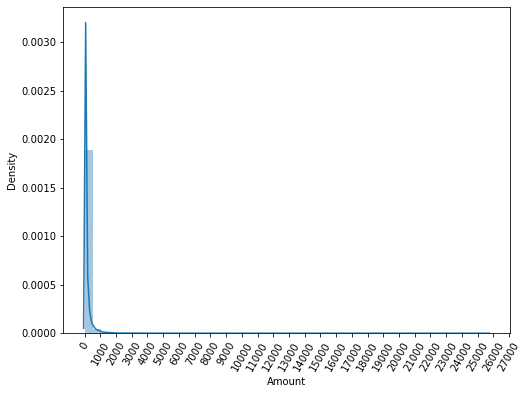

In [23]:
plt.figure(figsize = (8, 6))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(card_df['Amount'])

In [12]:
# Amount를 정규 분포 형태로 벼환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test  = get_train_test_dataset(card_df)

print("###로지스틱 회귀 예측 성능###")
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test, trgt_train = y_train, trgt_test = y_test)

print("###LightGBM 예측 성능###")
get_model_train_eval(lgbm_clf,ftr_train=X_train, ftr_test = X_test, trgt_train = y_train, trgt_test = y_test)

###로지스틱 회귀 예측 성능###
오차 행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.8750, 재현율 : 0.8750,                 F1 스코어 : 0.7597, FOC AUC값 : 0.9743
###LightGBM 예측 성능###
[LightGBM] [Warning] Unknown parameter: n_esitmators
오차 행렬
[[85288     7]
 [   28   118]]
정확도 : 0.9996, 정밀도 : 0.9440, 재현율 : 0.9440,                 F1 스코어 : 0.8708, FOC AUC값 : 0.9701


* 정규분포 형태로 Amount 피처값을 변환 한 후 , 테스트 데이터세트에 적용한 로지스틱회귀 및 LightGBM 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지 않음.

* `np.lop1p()`로 변환후에는 성능이 일정부분 개선됨을 확인할 수 있다.(통계적으로 심하게 왜곡된 데이터세트이 경우)

## 이상치 데이터 제거 후 모델 학습/예측/평가
* 히트맵을 통한 상관도를 통해 관계 파악

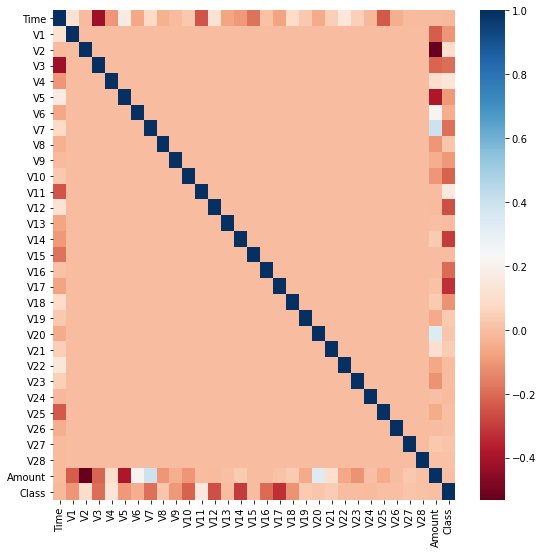

In [54]:
import seaborn as sns

plt.figure(figsize = (9, 9))
corr = card_df.corr()

sns.heatmap(corr, cmap = 'RdBu')

* 확인결과,V14, V17특성이 음의 상관관계를 높다.일단 V14에서 이상치데이터를 찾아 제거하기로 결정

In [13]:
import numpy as np

def get_outlier(df= None, column = None, weight = 1.5):
    """
    데이터프레임에서 컬럼정보를 
    받아 이상치를 찾아서 인덱스를 리턴한다.
    """
    #fraud에 해당하는 컬럼데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함.
    fraud = df[df['Class'] == 1][column]
    
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = (quantile_75 - quantile_25) * weight
    
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index  = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [26]:
outlier_index = get_outlier(card_df, column = 'V14', weight = 1.5)
print("이상치 데이터  : \n", card_df.loc[outlier_index])
card_df.loc[outlier_index]['V14']

이상치 데이터  : 
          Time        V1        V2         V3         V4        V5        V6  \
8296  11080.0 -2.125490  5.973556 -11.034727   9.007147 -1.689451 -2.854415   
8615  11629.0 -3.891192  7.098916 -11.426467   8.607557 -2.065706 -2.985288   
9035  12597.0 -2.589617  7.016714 -13.705407  10.343228 -2.954461 -3.055116   
9252  13323.0 -5.454362  8.287421 -12.752811   8.594342 -3.106002 -3.179949   

            V7        V8        V9  ...       V21       V22       V23  \
8296 -7.810441  2.030870 -5.902828  ...  1.646518 -0.278485 -0.664841   
8615 -8.138589  2.973928 -6.272790  ...  1.757085 -0.189709 -0.508629   
9035 -9.301289  3.349573 -5.654212  ...  1.887738  0.333998  0.287659   
9252 -9.252794  4.245062 -6.329801  ...  1.846165 -0.267172 -0.310804   

           V24       V25       V26       V27       V28  Amount  Class  
8296 -1.164555  1.701796  0.690806  2.119749  1.108933     1.0      1  
8615 -1.189308  1.188536  0.605242  1.881529  0.875260     1.0      1  
9035 -1.1

8296   -19.214325
8615   -18.822087
9035   -18.493773
9252   -18.049998
Name: V14, dtype: float64

### 이상치를 제거한 데이터세트를 이용해 로지스틱회귀와 LightGBM적용

In [14]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print("####로지스틱 회귀 예측 성능#####")
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test, trgt_train = y_train, trgt_test = y_test)

####로지스틱 회귀 예측 성능#####
오차 행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.8750, 재현율 : 0.8750,                 F1 스코어 : 0.7597, FOC AUC값 : 0.9743


In [15]:
print("####LightGBM 예측 성능#####")
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test = X_test, trgt_train = y_train, trgt_test = y_test)

####LightGBM 예측 성능#####
[LightGBM] [Warning] Unknown parameter: n_esitmators
오차 행렬
[[85288     7]
 [   28   118]]
정확도 : 0.9996, 정밀도 : 0.9440, 재현율 : 0.9440,                 F1 스코어 : 0.8708, FOC AUC값 : 0.9701


### SMOTE기법을 이용한 오버샘플링 적용 후 모델 학습 / 예측/평가
* SMOTE를 적용할때는 반드시 학습 데이터 세트만 오버 샘플링을 해야 합니다. 

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)

X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

* 대략적으로 2배정도가 뻥튀기 되었다고 볼 수 있다.

In [17]:
print("SMOTE적용 전 학습용 피처/페이블 데이터 세트 : ", X_train.shape, y_train.shape)
print("SMOTE적용 후 학습용 피처/페이블 데이터 세트 : ", X_train_over.shape, y_train_over.shape)
print("SMOTE적용 후 레이블 값 분포 : ", pd.Series(y_train_over).value_counts())

SMOTE적용 전 학습용 피처/페이블 데이터 세트 :  (199362, 29) (199362,)
SMOTE적용 후 학습용 피처/페이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE적용 후 레이블 값 분포 :  1    199020
0    199020
Name: Class, dtype: int64


### 로지스틱 회귀 성능 평가

In [18]:
lr_clf = LogisticRegression()

# ftr_train과 trgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf,ftr_train = X_train_over, ftr_test = X_test, trgt_train = y_train_over, trgt_test = y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도 : 0.9723, 정밀도 : 0.0542, 재현율 : 0.0542,                 F1 스코어 : 0.1023, FOC AUC값 : 0.9737


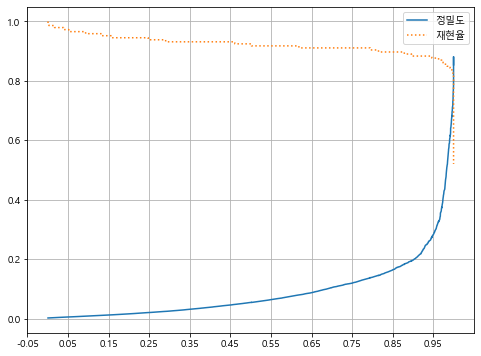

In [21]:
import evaluation
evaluation.precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [22]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf,ftr_train = X_train_over, ftr_test = X_test, trgt_train = y_train_over, trgt_test = y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도 : 0.9996, 정밀도 : 0.9118, 재현율 : 0.9118,                 F1 스코어 : 0.8794, FOC AUC값 : 0.9814


* SMOTE를 적용하면, 정밀도는 낮아지고 재현율은 높아지는것이 일반적이다.뻥튀기를 한 샘플링 데이터를 가지고 훈련시켰기 때문에?